The following cell performs the initialisation of modules and data read-in,
unless this is changed, or the read-in data modified, it only needs to be run once each time the notebook is opened

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

#function for converting the byte object version of the date and time into a datetime object
def strtodatetime(x):
    return dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

datapath = 'C:/Users/tmk5/Downloads/' #this should be your own path containing the data file - make sure the path uses forward slashes, /, not backslashes, \ (the latter is the Windows default, but not compatible with Python)
datafile = 'Weather_all.csv' #name of the data file itself

#header=0 specifies that the first row (index 0) is the header
#converters={0:strtodatetime} modifies the strings forming the dates in the file into datetime objects
#index_col=0 specifies that the first column (the datetimes) are what the data are indexed on
data = pd.read_csv(datapath+datafile,header=0,converters={0:strtodatetime},index_col=0)
data.columns = data.columns.str.replace(' ', '') #strip spaces from the column headings
data.columns = data.columns.str.replace('#', '') #strip hash symbol from the column headings
data[data < -99998] = np.nan #replace all missing data (with it's default -99999) with numpy nans, as this is understood as missing data by pandas


The following cell shows a quick check of the data read in above

In [3]:
#print(f"Read in {len(data['DateTime'])} dates and times, earliest is {np.min(data['DateTime'])} and latest is {np.max(data['DateTime'])}, duration is {np.max(data['DateTime']) - np.min(data['DateTime'])}")

print('\nColumn info')
print(data.columns) #show all of the column names

print('\nDataset basic stats')
print(data.describe()) #shows basic stats of all columns


Column info
Index(['TE', 'WU', 'RT', 'WK', 'WR', 'WT', 'WG', 'WS', 'WD', 'WV', 'TI', 'FI',
       'TX', 'FX'],
      dtype='object')

Dataset basic stats
                  TE             WU             RT             WK  \
count  684568.000000  684568.000000  684568.000000  684568.000000   
mean       10.806594    1231.345015       0.063154       0.868156   
std         5.955508    1035.642260       0.243239       0.338321   
min        -9.280000       0.000000       0.000000       0.000000   
25%         6.500000     221.220000       0.000000       1.000000   
50%        10.430000    1106.090000       0.000000       1.000000   
75%        14.890000    2063.810000       0.000000       1.000000   
max        56.820000   11422.500000       1.000000       1.000000   

                  WR             WT             WG            WS  \
count  684568.000000  684568.000000  684568.000000  684568.00000   
mean      195.467858      11.616141       7.938068      15.56197   
std        90.25149

The following cell produces a simple graph of all OAT readings over time, this uses only the default settings for a basic plot

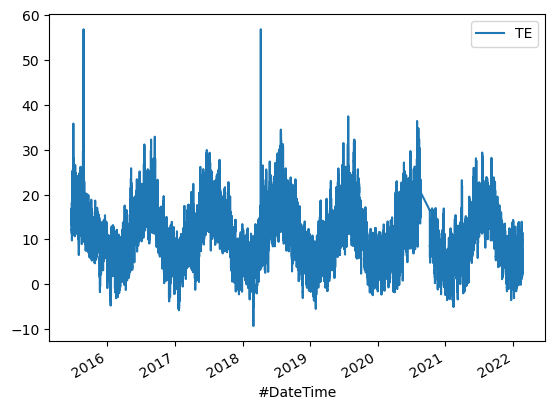

In [80]:
ax = data.plot(y="TE")

The following example is a more elaborate version of the same data

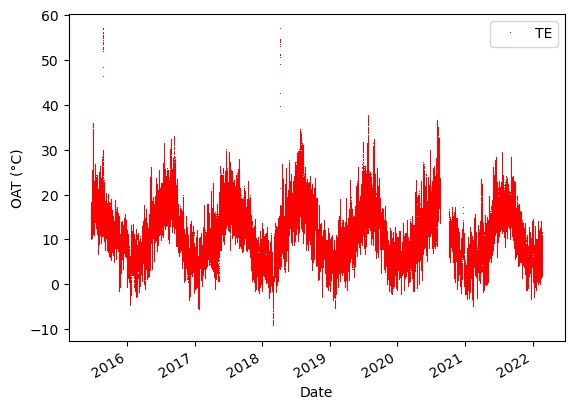

In [60]:
ax = data.plot(y="TE",xlabel='Date',ylabel='OAT (°C)',linestyle='none',marker=',',color='red')

The following is one approach to selecting a particular range of dates to plot OAT. Note that the original data is not modified; we are just selecting a subset at the time of plotting and using that. Modifying source data is potentially fragile as sequential runs may then be working on different data

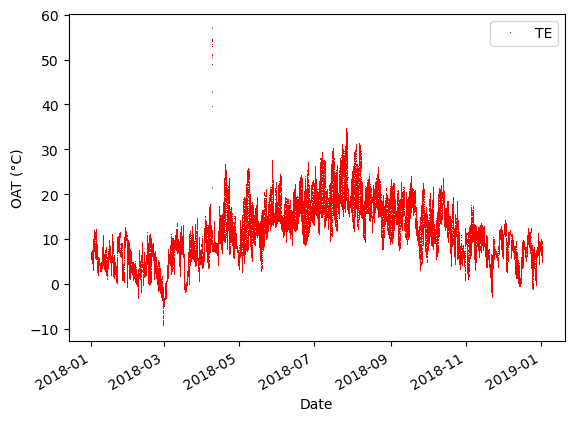

In [73]:
ax = data['2018-1-1':'2019-1-1'].plot(y="TE",xlabel='Date',ylabel='OAT (°C)',linestyle='none',marker=',',color='red')

Of note in the previous plot are some outlier points approaching 60°C. These are likely anomalous. The following example trims the most egregious ones.

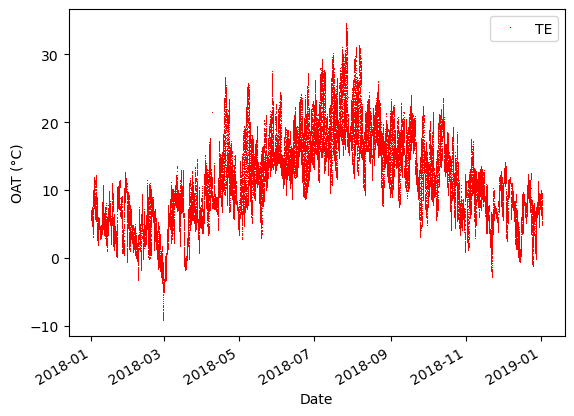

In [82]:
ax = data['2018-1-1':'2019-1-1'].query('TE < 35 and TE > -20').plot(y="TE",xlabel='Date',ylabel='OAT (°C)',linestyle='none',marker=',',color='red')

The following is how pandas provides an easy way to resample by grouped dates; in this case reducing to a single datapoint per day, calculated using the mean

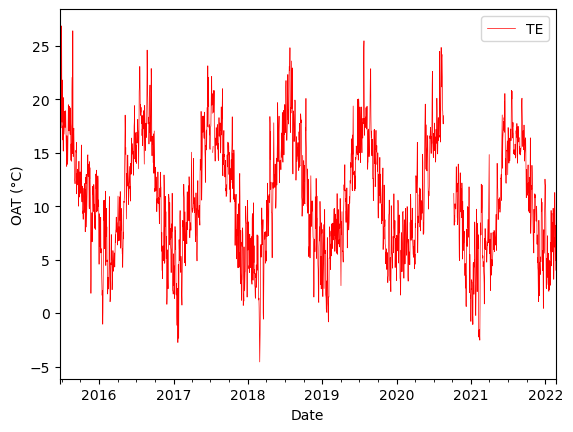

In [76]:
ax = data.resample("1D",origin='start_day').mean().plot(y="TE",xlabel='Date',ylabel='OAT (°C)',linestyle='solid',linewidth=0.5,marker='none',color='red')

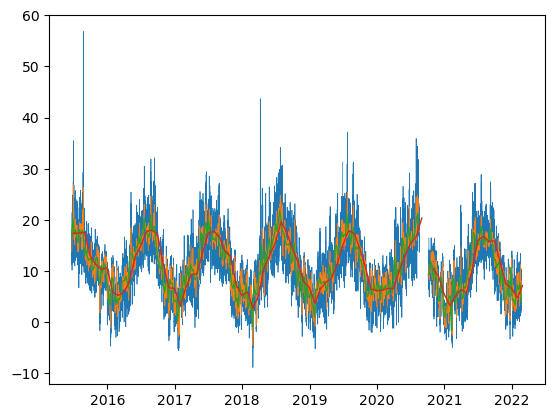

In [92]:
#This is similar, comparing several different "smoothnesses"
d1h = data.resample("1h",origin='start_day').mean()
d1D = data.resample("1D",origin='start_day').mean()
d1W = data.resample("7D",origin='start_day').mean()
d1M = data.resample("1M",origin='start_day').mean()
plt.plot(d1h.index.array,d1h['TE'],lw=0.5,label='1 hour')
plt.plot(d1D.index.array,d1D['TE'],lw=0.5,label='1 day')
plt.plot(d1W.index.array,d1W['TE'],lw=1,label='1 week')
plt.plot(d1M.index.array,d1M['TE'],lw=1,label='1 month')
plt.show()

The following is an example of a histogram of the wind speed data using bins running from 1 km hr^-1 to 40 km hr^-1 with 100 bins total; an alternative approach to the bins might be: np.arange(1,40,0.5) for example. np.linspace() takes start, stop and quantity, calculated step by itself; np.arange() takes start, stop and step, calculating quantity by itself.
In addition, this example shows a slightly different approach to setting some of the plot features.

Text(0, 0.5, 'Count')

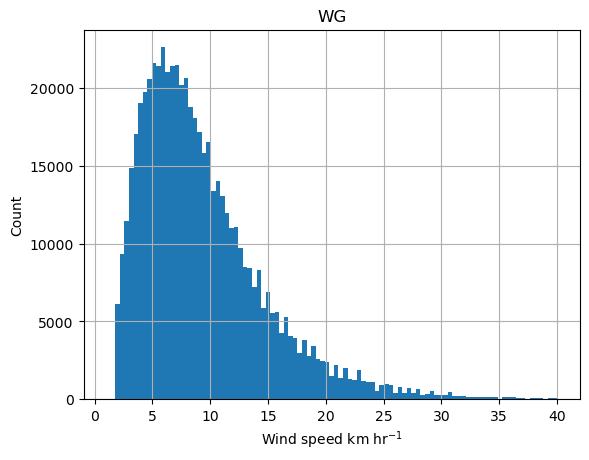

In [10]:
ax = data.hist('WG',bins=np.linspace(1,40,100))
ax[0,0].set_xlabel('Wind speed km hr$^{-1}$')
ax[0,0].set_ylabel('Count')

There are many plot types available (search matplotlib online to access the documentation and lots of examples), below is an example of the .hist2d() plot type, giving a 2 dimensional histogram of the outside air temperature and inside air temperature. Some interesting patterns can be found in this plot, think about what it might show.

Unlike the earlier plot types, hist2d did not appear to be available as a method to a pandas dataframe; this shows how to exact each individual column and use the separate matplotlib command for plotting.

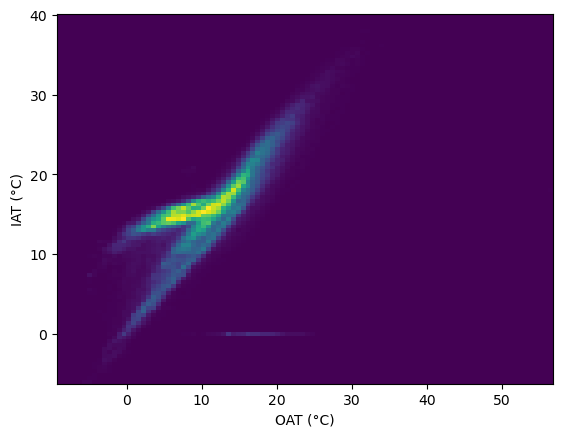

In [12]:
plt.hist2d(data['TE'],data['TI'],bins=[100,100])
plt.xlabel('OAT (°C)')
plt.ylabel('IAT (°C)')
plt.show()

The following example illustrates fitting data with a polynomial (although in this case order 1). The steps are elaborated in the comments within the code.

Fitted coefficients [1.00109333 1.1175704 ]


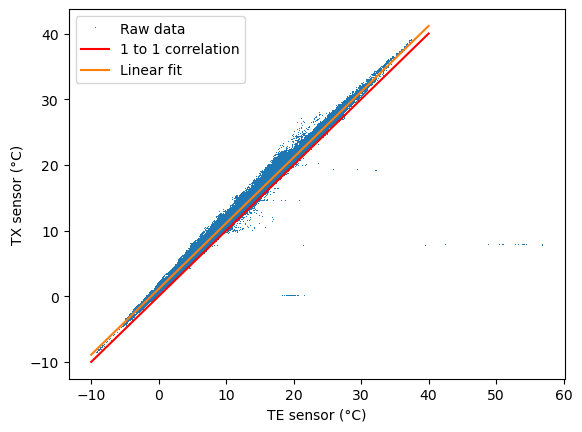

In [15]:
#this plots the two outside air temperature sensors against one another
#the "label" argument lets the legend know what to call the series
plt.plot(data['TE'],data['TX'],linestyle='none',marker=',',label='Raw data')

#this draws a red line with intercept=0 and gradient=1; corresponding to
#the two measurements perfectly agreeing
plt.plot([-10,40],[-10,40],'r-',label='1 to 1 correlation')

#this applies polyfit - it takes 3 arguments: xdata, ydata and polynomial order
#it returns a numpy array with as many items as there are orders of x
#in this case - the coefficients for the x^1 and x^0 terms, the gradient and
#intercept
#The data used have "query" applied to deselect the np.nan data - polyfit will
#fail if there are np.nan values in the dataset
popt = np.polyfit(data.query('TX > -100')['TE'],data.query('TX > -100')['TX'],1)

#presents the fitted coefficients
print('Fitted coefficients',popt)

#this sets up two data points as a numpy array to represent the range on
#the x-axis for which a plotted fit is desired
xs = np.linspace(-10,40,2)

#polyval takes two arguements: the coefficients (it determines order from the
#number of coefficients) and the locations at which to evaluate the polynomial
plt.plot(xs,np.polyval(popt,xs),label='Linear fit')


plt.xlabel('TE sensor (°C)')
plt.ylabel('TX sensor (°C)')

#adds the legend
plt.legend()

plt.show()

The following several cells are an example of a more complex fitting approach.
The first cell does the pre-processing necessary - this takes a little longer than the other operations, and only needs to be done once per data read; so is separated from the plotting commands.

In [17]:
#scipy provides the "curve_fit" method within optimize we will be using this
#for the fitting itself. In this example we import only that one function,
#rather than all of the scipy module functions
from scipy.optimize import curve_fit

#for curve_fit, we must define a Python function which behaves as our
#mathmatical function to fit. The first argument *must* the the axis variable
#(in this case time) and the remaining arguments are all parameters we wish
#to fit
def sinusoid(t,A,w,phi,vert):
    return A * np.sin((t + phi)*(w*2*np.pi)) + vert
#in this case, we attempt to fit a general purpose sinusoid, fitting:
#amplitude A
#frequency w
#phase offset phi
#vertical offset vert

#unfortunately, np.sin() only takes arguments interpretable as radians. Our
#datetime object can't be understood. So, we must convert the datetimes into
#single numbers. The following code converts the times into the fraction of a
#year since the start of the dataset
start = np.min(data.index) #here we note the very first datetime in the data
times = np.array([ (mytime - start).total_seconds()/(60*60*24*365.25) for mytime in data.index.values ])
#the above line breaks down as follows:
#it uses a "list constructor", the things in the square brackets
#this takes each datetime from data.index.values (the actual datetimes),
#labels it as "mytime" then performs:
#(mytime - start).total_seconds()/(60*60*24*365.25)
#on it and stores the result. This takes the difference between mytime and start, giving a timedelta
#object. The timedelta object has a method .total_seconds() which converts this
#into a single number of seconds elapsed.
#this is then divided by (60*60*24*365.25) to express it as a fraction of a year
#finally, np.array() turns the list back into a numpy array for future use

#This is not actually an especially efficient way to do this, and mapping
#functions across the datetime array is better; but more complex and relies on
#more fiddly Python knowledge


Fitted parameters [ 6.36978322  0.99977854  0.15284958 10.88580171]


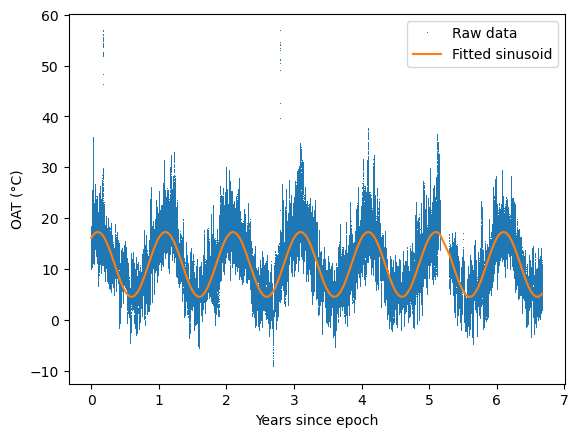

In [20]:
#plot the raw data
plt.plot(times, data['TE'], ',', label='Raw data')

#This applies curve_fit using our defined function and the data.
#curve_fit takes 3 main arguments: the function to fit, xdata and ydata.
#in this case we also provide "p0", which are our own initial guesses for
#each of the fitted parameters - try running it without these guesses;
#it should fail to find an appropriate solution. This is more likely the more
#complex the function and the larger number of free parameters
popt, pcov = curve_fit(sinusoid,times, data['TE'],p0=[10,1,0.3,10])
#curve_fit gives back optimised parameters (popt, here) and the covariance
#matrix (pcov, here) for those parameters

#displays the fitted parameters
print('Fitted parameters',popt)

#this plots the fitted function; note that "*popt" rather that just "popt" is
#used, this is intentional and separates the items in the list/array before
#giving them to the function
plt.plot(times,sinusoid(times,*popt),label='Fitted sinusoid')

plt.xlabel('Years since epoch')
plt.ylabel('OAT (°C)')

plt.legend()

plt.show()

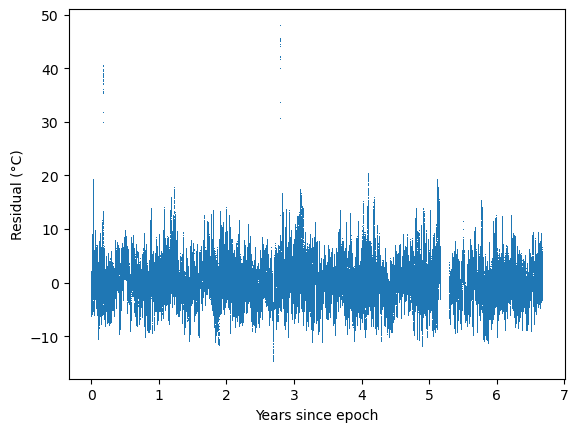

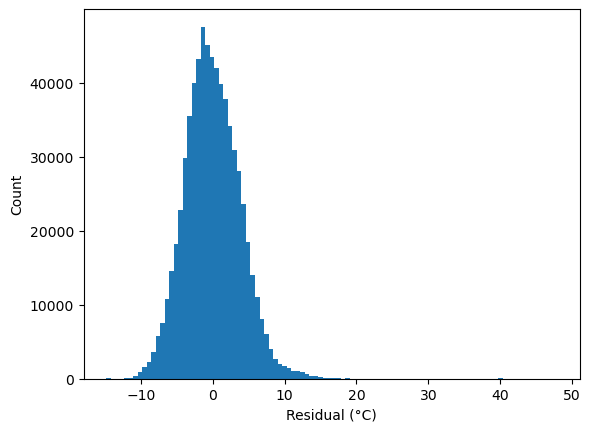

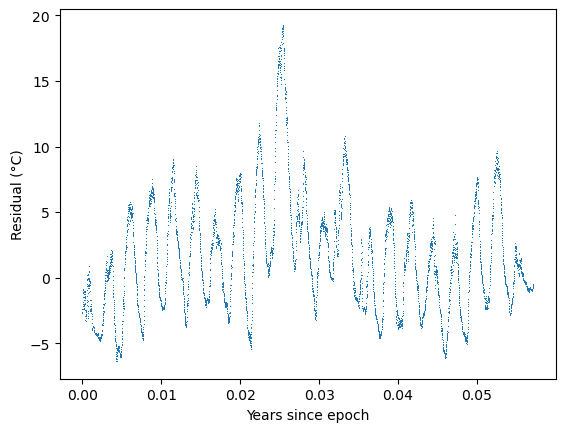

In [23]:
#This shows a couple of ways to examine the nature of the fit

#calculate the residual of data - fit
residual = data['TE'] - sinusoid(times,*popt)

#plot the residual as a function of time - this may let us see larger variations
#from the expected behaviour which are time dependant
plt.plot(times,residual,',')
plt.ylabel('Residual (°C)')
plt.xlabel('Years since epoch')
plt.show()

#plot the histogram of the residuals - this shows the distribution of the data
#around the fit
plt.hist(residual,bins=100)
plt.xlabel('Residual (°C)')
plt.ylabel('Count')
plt.show()


#This replots the residuals against time over a shorter range. Here we can
#clearly see there is a second oscillatory pattern overlaid on the annual
#variation - the daily temperature cycle showing itself in the residuals
plt.plot(times[:6000],residual[:6000],',')
plt.ylabel('Residual (°C)')
plt.xlabel('Years since epoch')
plt.show()